<a href="https://colab.research.google.com/github/seongs/ML/blob/main/ksy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import



In [ ]:
import random
import pandas as pd
import numpy as np
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings(action='ignore')

# Fixed Random-Seed

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

#Load Data

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/데이콘/제주 특산물 가격 예측 AI 경진대회/open/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/데이콘/제주 특산물 가격 예측 AI 경진대회/open/test.csv')


#Data Pre-Processing

In [ ]:
#시계열 특성을 학습에 반영하기 위해 timestamp를 월, 일, 시간으로 나눕니다
train_df['year'] = train_df['timestamp'].apply(lambda x : int(x[0:4]))
train_df['month'] = train_df['timestamp'].apply(lambda x : int(x[5:7]))
train_df['day'] = train_df['timestamp'].apply(lambda x : int(x[8:10]))

test_df['year'] = test_df['timestamp'].apply(lambda x : int(x[0:4]))
test_df['month'] = test_df['timestamp'].apply(lambda x : int(x[5:7]))
test_df['day'] = test_df['timestamp'].apply(lambda x : int(x[8:10]))

In [ ]:
test_df.head()

,ID,timestamp,item,corporation,location,year,month,day
0,TG_A_J_20230304,2023-03-04,TG,A,J,2023,3,4
1,TG_A_J_20230305,2023-03-05,TG,A,J,2023,3,5
2,TG_A_J_20230306,2023-03-06,TG,A,J,2023,3,6
3,TG_A_J_20230307,2023-03-07,TG,A,J,2023,3,7
4,TG_A_J_20230308,2023-03-08,TG,A,J,2023,3,8


In [ ]:
train_df['location'].unique()

array(['J', 'S'], dtype=object)

In [ ]:
# 이상치 식별과 제거
Q1 = train_df['price(원/kg)'].quantile(0.25)  # 1사분위수
Q3 = train_df['price(원/kg)'].quantile(0.75)  # 3사분위수
IQR = Q3 - Q1

# 이상치 경계 계산
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치 제거
train_df = train_df[(train_df['price(원/kg)'] >= lower_bound) & (train_df['price(원/kg)'] <= upper_bound)]

# 이상치가 제거된 데이터프레임 확인
train_df.head()


,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),year,month,day
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,2
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,3
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,4
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,5


In [ ]:
# 요일
import calendar
from datetime import datetime

train_df ['weekday'] = train_df['timestamp'].apply( lambda x:
        calendar.day_name[ datetime.strptime(x.split()[0], '%Y-%m-%d').weekday() ])

In [ ]:
test_df ['weekday'] = test_df['timestamp'].apply( lambda x:
        calendar.day_name[ datetime.strptime(x.split()[0], '%Y-%m-%d').weekday() ])

In [ ]:
train_df['weekday'] = train_df['timestamp'].apply( lambda x: datetime.strptime( x.split()[0], '%Y-%m-%d' ).weekday() )
train_df.head()

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),year,month,day,weekday
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,1
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,2,2
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,3,3
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,4,4
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,5,5


In [ ]:
test_df['weekday'] = test_df['timestamp'].apply( lambda x: datetime.strptime( x.split()[0], '%Y-%m-%d' ).weekday() )
test_df.head()

,ID,timestamp,item,corporation,location,year,month,day,weekday
0,TG_A_J_20230304,2023-03-04,TG,A,J,2023,3,4,5
1,TG_A_J_20230305,2023-03-05,TG,A,J,2023,3,5,6
2,TG_A_J_20230306,2023-03-06,TG,A,J,2023,3,6,0
3,TG_A_J_20230307,2023-03-07,TG,A,J,2023,3,7,1
4,TG_A_J_20230308,2023-03-08,TG,A,J,2023,3,8,2


In [ ]:
#계절변환 함수
def month_to_season(month):
    if month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    elif month in [9, 10, 11]:
        return 3
    else:
        return 4

In [ ]:
train_df['season'] = train_df['month'].apply(month_to_season)
test_df['season'] = test_df['month'].apply(month_to_season)

In [ ]:
test_df.info()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           1092 non-null   object
 1   timestamp    1092 non-null   object
 2   item         1092 non-null   object
 3   corporation  1092 non-null   object
 4   location     1092 non-null   object
 5   year         1092 non-null   int64 
 6   month        1092 non-null   int64 
 7   day          1092 non-null   int64 
 8   weekday      1092 non-null   int64 
 9   season       1092 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 85.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52795 entries, 0 to 59396
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           52795 non-null  object 
 1   timestamp    52795 non-null  object 
 2   item         52795 non-null  object 
 3   corporation  52795 non-nul

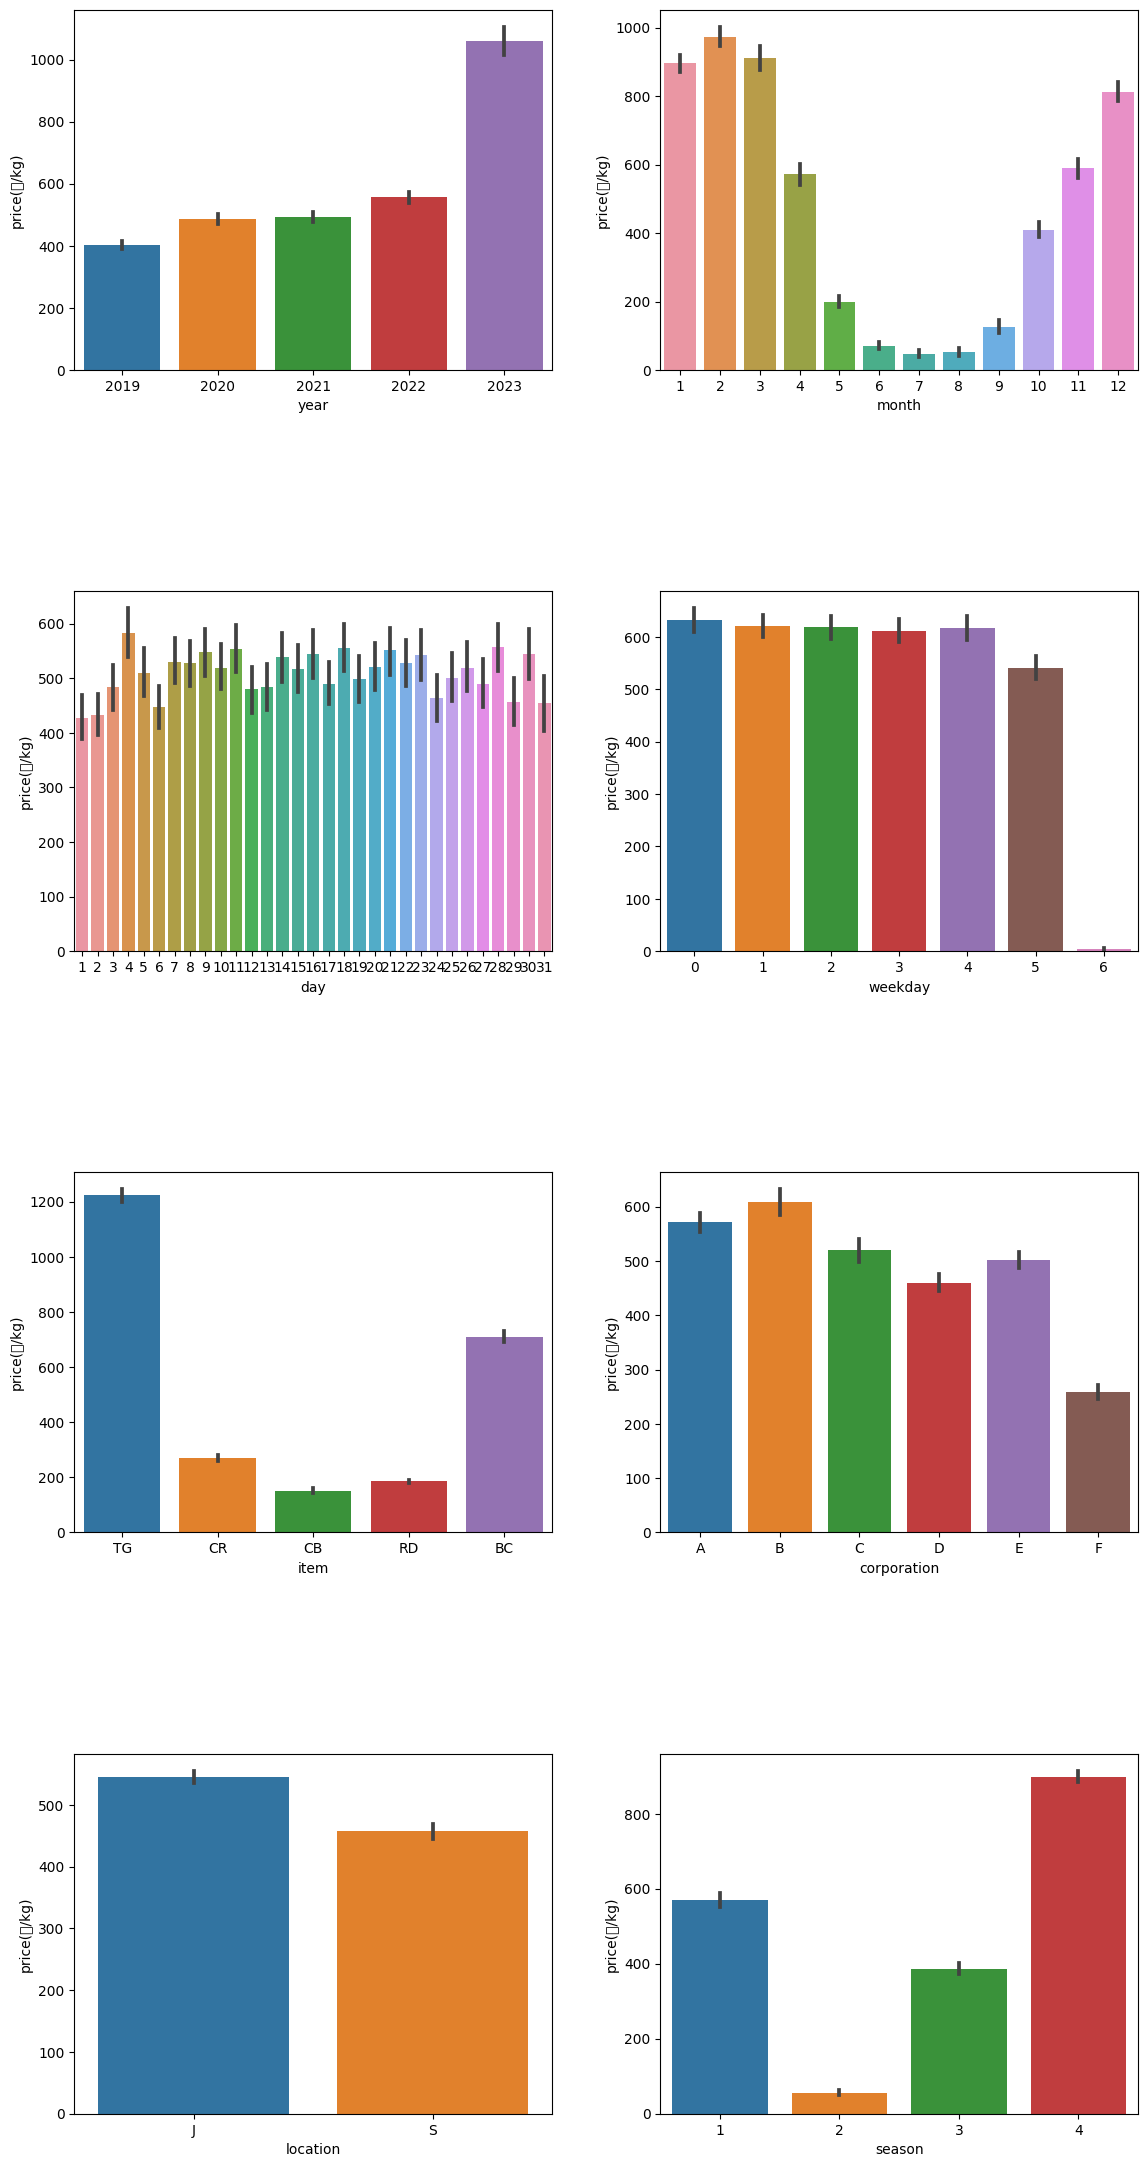

In [ ]:
nrows, ncols = 4, 2
fig, axes = plt.subplots( nrows = nrows, ncols = ncols )
plt.tight_layout()
fig.set_size_inches( 6*ncols, 6*nrows )

# 바차트 + 오차범위 추가(이것을 기준으로 변별력이 있는지 체크)
sns.barplot( x='year', y='price(원/kg)', data=train_df, ax=axes[0, 0])
sns.barplot( x='month', y='price(원/kg)', data=train_df, ax=axes[0, 1])
sns.barplot( x='day', y='price(원/kg)', data=train_df, ax=axes[1, 0])
sns.barplot( x='weekday', y='price(원/kg)', data=train_df, ax=axes[1, 1])
sns.barplot( x='item', y='price(원/kg)', data=train_df, ax=axes[2, 0])
sns.barplot( x='corporation', y='price(원/kg)', data=train_df, ax=axes[2, 1])
sns.barplot( x='location', y='price(원/kg)', data=train_df, ax=axes[3, 0])
sns.barplot( x='season', y='price(원/kg)', data=train_df, ax=axes[3, 1])



plt.show()

In [ ]:
train_df.shape

(52795, 12)

In [ ]:
train_df = train_df[ train_df[ 'weekday' ] != 6 ]
train_df.shape

(44332, 12)

In [ ]:
#학습에 사용하지 않을 변수들을 제거합니다
train_x = train_df.drop(columns=['ID', 'timestamp', 'supply(kg)', 'price(원/kg)'])
train_y = train_df['price(원/kg)']

test_x = test_df.drop(columns=['ID', 'timestamp',])

In [ ]:
#질적 변수들을 수치화합니다
qual_col = ['item', 'corporation', 'location']

for i in qual_col:
    le = LabelEncoder()
    train_x[i]=le.fit_transform(train_x[i])
    test_x[i]=le.transform(test_x[i]) #test 데이터에 대해서 fit하는 것은 data leakage에 해당합니다

print('Done.')

Done.


In [ ]:
train_df.isnull().sum()

ID             0
timestamp      0
item           0
corporation    0
location       0
supply(kg)     0
price(원/kg)    0
year           0
month          0
day            0
weekday        0
season         0
dtype: int64

In [ ]:
test_df.isnull().sum()

ID             0
timestamp      0
item           0
corporation    0
location       0
year           0
month          0
day            0
weekday        0
season         0
dtype: int64

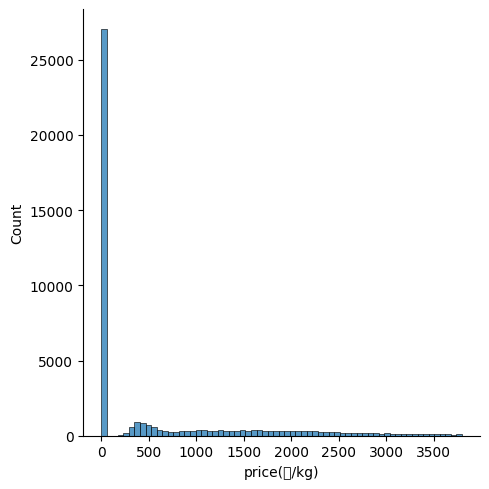

In [ ]:
sns.displot( train_df['price(원/kg)'] );

In [ ]:
corr_values =train_x.corr()
corr_values

,item,corporation,location,year,month,day,weekday,season
item,1.000000,0.080488,0.061580,0.000977,0.020493,-0.008251,0.005890,0.131308
corporation,0.080488,1.000000,-0.090206,0.002713,-0.002981,0.000740,0.000747,-0.019697
location,0.061580,-0.090206,1.000000,0.001694,0.005855,0.000091,0.000383,0.032713
year,0.000977,0.002713,0.001694,1.000000,-0.110724,-0.016690,-0.001974,0.094602
month,0.020493,-0.002981,0.005855,-0.110724,1.000000,0.027410,-0.001354,0.092995
day,-0.008251,0.000740,0.000091,-0.016690,0.027410,1.000000,-0.006743,-0.003891
weekday,0.005890,0.000747,0.000383,-0.001974,-0.001354,-0.006743,1.000000,-0.000346
season,0.131308,-0.019697,0.032713,0.094602,0.092995,-0.003891,-0.000346,1.000000


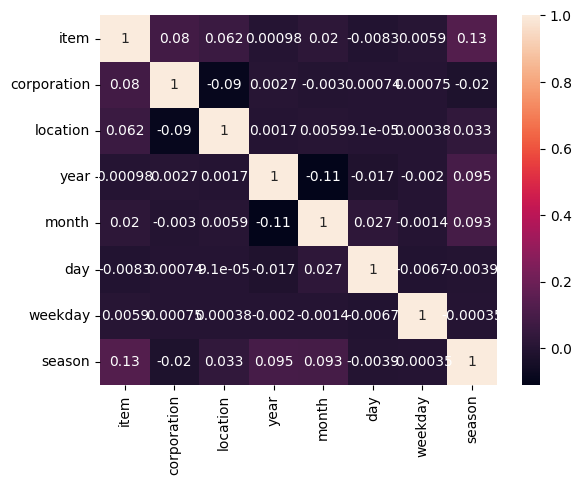

In [ ]:
sns.heatmap( corr_values, annot=True);

In [ ]:
print(test_df.head())

                ID   timestamp item corporation location  year  month  day  \
0  TG_A_J_20230304  2023-03-04   TG           A        J  2023      3    4   
1  TG_A_J_20230305  2023-03-05   TG           A        J  2023      3    5   
2  TG_A_J_20230306  2023-03-06   TG           A        J  2023      3    6   
3  TG_A_J_20230307  2023-03-07   TG           A        J  2023      3    7   
4  TG_A_J_20230308  2023-03-08   TG           A        J  2023      3    8   

   weekday  season  
0        5       1  
1        6       1  
2        0       1  
3        1       1  
4        2       1  


#Regression Model Fit

In [ ]:
model = RandomForestRegressor()
model.fit(train_x, train_y)

RandomForestRegressor()

In [ ]:
train_x.columns

Index(['item', 'corporation', 'location', 'year', 'month', 'day', 'weekday',
       'season'],
      dtype='object')

# Inference

In [ ]:
preds = model.predict(test_x)
preds

array([3244.71, 3157.75, 3281.23, ...,  462.55,  434.78,  420.68])

In [ ]:
model.score(train_x, train_y)

0.9762280281364949

In [ ]:
model.feature_importances_

array([0.37150829, 0.11488342, 0.07268332, 0.07153946, 0.17898925,
       0.12057192, 0.04473392, 0.02509041])

#Submission

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/데이콘/제주 특산물 가격 예측 AI 경진대회/open/sample_submission.csv')
submission

,ID,answer
0,TG_A_J_20230304,0
1,TG_A_J_20230305,0
2,TG_A_J_20230306,0
3,TG_A_J_20230307,0
4,TG_A_J_20230308,0
...,...,...
1087,RD_F_J_20230327,0
1088,RD_F_J_20230328,0
1089,RD_F_J_20230329,0
1090,RD_F_J_20230330,0


In [ ]:
submission['answer'] = preds
submission

,ID,answer
0,TG_A_J_20230304,3244.71
1,TG_A_J_20230305,3157.75
2,TG_A_J_20230306,3281.23
3,TG_A_J_20230307,3089.82
4,TG_A_J_20230308,3179.94
...,...,...
1087,RD_F_J_20230327,479.01
1088,RD_F_J_20230328,490.04
1089,RD_F_J_20230329,462.55
1090,RD_F_J_20230330,434.78


In [ ]:
!pip install -q catboost
!pip install --upgrade -q xgboost
!pip install -q pycaret

ERROR: Operation cancelled by user
ERROR: Operation cancelled by user


In [ ]:
from pycaret.regression import *

In [ ]:
reg = setup( data=train_x,
             target= train_y,
             verbose=True,

             data_split_shuffle=True,
             normalize=True)

,Description,Value
0,Session id,1974
1,Target,price(원/kg)
2,Target type,Regression
3,Original data shape,"(44332, 9)"
4,Transformed data shape,"(44332, 9)"
5,Transformed train set shape,"(31032, 9)"
6,Transformed test set shape,"(13300, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


In [ ]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [ ]:
top6_models = compare_models( fold=5, round=3, n_select=6, errors='ignore')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,188.201,182487.027,427.003,0.803,2.356,0.210,6.438
et,Extra Trees Regressor,180.308,184303.628,429.204,0.801,2.193,0.207,3.262
xgboost,Extreme Gradient Boosting,249.380,197800.881,444.599,0.786,3.527,0.260,0.476
catboost,CatBoost Regressor,254.530,200222.688,447.361,0.784,3.561,0.261,5.476
lightgbm,Light Gradient Boosting Machine,252.479,212649.812,461.055,0.770,3.378,0.271,1.006
dt,Decision Tree Regressor,206.453,305431.187,552.504,0.670,2.055,0.270,0.178
gbr,Gradient Boosting Regressor,380.910,346107.123,588.274,0.626,4.044,0.358,1.322
knn,K Neighbors Regressor,336.680,371335.762,609.349,0.599,2.977,0.359,0.538
ada,AdaBoost Regressor,589.043,564102.451,750.984,0.391,4.887,0.341,0.336
ridge,Ridge Regression,688.223,829015.136,910.491,0.105,4.825,0.611,0.130


Processing:   0%|          | 0/90 [00:00<?, ?it/s]

In [ ]:
top6_models

[RandomForestRegressor(n_jobs=-1, random_state=1974),
 ExtraTreesRegressor(n_jobs=-1, random_state=1974),
 XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=1974, ...),
 LGBMRegressor(n_jobs=-1, random_state=1974),
 DecisionTreeRegressor(random_state=1974)]

In [ ]:
reg_blended = blend_models(estimator_list=top6_models, fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,197.2630,158756.5681,398.4427,0.8252,3.0524,0.2180
1,194.2332,148105.3763,384.8446,0.8448,2.9831,0.2160
2,198.6256,155403.7415,394.2128,0.8293,3.0962,0.2052
3,207.6424,179556.5519,423.7411,0.8108,3.0250,0.2240
4,217.2191,199363.9128,446.5019,0.7927,3.0689,0.2149
5,191.0233,152034.1741,389.9156,0.8337,3.0990,0.2099
6,213.0181,189677.3394,435.5196,0.8009,3.0602,0.2269
7,193.4257,162931.9779,403.6483,0.8136,3.1118,0.2072
8,200.8521,164581.2274,405.6861,0.8214,3.0950,0.2066


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
model = finalize_model( reg_blended )
model

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['item', 'corporation', 'location',
                                             'year', 'month', 'day', 'weekday',
                                             'season'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('normalize', TransformerWrapper(transformer=St...
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=None,
                                                           n_jobs=-1,
                                                           num_parallel_tree=None,
                                                           random_state=1974, ...)),
                                             ('CatBoost Regressor',
                                              <catboost.core.CatBoostRegressor object at 0x7b608c732c50>),
                                             ('Light Gradient Boosting Machine',
                                              LGBMRegressor(n_jobs=-1,
                                                            random_state=1974)),
                                             ('Decision Tree Regressor',
                                              DecisionTreeRegressor(random_state=1974))],
                                 n_jobs=-1))])

In [ ]:
preds = model.predict(test_x)
preds

array([3099.06076238, 3093.00659937, 3104.58295106, ...,  415.56536232,
        410.80692999,  420.46273778])

In [ ]:
submission['answer'] = preds
submission

,ID,answer
0,TG_A_J_20230304,3099.060762
1,TG_A_J_20230305,3093.006599
2,TG_A_J_20230306,3104.582951
3,TG_A_J_20230307,3024.955211
4,TG_A_J_20230308,3075.648042
...,...,...
1087,RD_F_J_20230327,493.413997
1088,RD_F_J_20230328,450.633089
1089,RD_F_J_20230329,415.565362
1090,RD_F_J_20230330,410.806930


In [ ]:
submission.to_csv('ksy_1104_1.csv', index=False)